### Analyze metadata predictions

In [1]:
import os
import torch
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import typing as t
import pickle
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)  # Set the logging level

# Create a handler
handler = logging.StreamHandler()

# Create and set a formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

# To suppress the stupid AnnData warning ...
warnings.filterwarnings("ignore", category=UserWarning, message="Transforming to str index.")

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext
from cellarium.ml.utilities.inference.metadata_benchmarking.calculate_metrics import \
    calculate_metrics_for_prediction_output

In [2]:
ROOT_PATH = "/home/mehrtash/data"
METADATA_PREDICTIONS_ROOT_PATH = os.path.join(ROOT_PATH, "data", "metadata_predictions_rand_4091")
PREFIX_LIST = [
    "10M_001_bs1536",
    "19M_001_bs2048",
    "30M_001_bs2560",
    "59M_001_bs3072"
]
VAL_ADATA_IDX_RANGE = np.arange(1, 111)
N_HOPS_DICT = {
    'cell_type': 3,
    'development_stage': 3,
    'disease': 3,
    'tissue': 3,
    'sex': 0,
}

def load_predictions_anndata(val_adata_idx: int, prefix_idx: int) -> sc.AnnData:
    path = os.path.join(
        METADATA_PREDICTIONS_ROOT_PATH,
        PREFIX_LIST[prefix_idx],
        f"extract_{VAL_ADATA_IDX_RANGE[val_adata_idx]}_metadata_prediction_scores.h5ad")
    return sc.read_h5ad(path)

In [6]:
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize


results = defaultdict(list)
top_k_list = [1, 3, 5, 10]

for prefix_idx in tqdm(range(len(PREFIX_LIST))):
    prefix = PREFIX_LIST[prefix_idx]
    
    for val_adata_idx in tqdm(range(len(VAL_ADATA_IDX_RANGE))):
        val_adata_id = VAL_ADATA_IDX_RANGE[val_adata_idx]
        meta_adata = load_predictions_anndata(val_adata_idx, prefix_idx)
        results["prefix"].append(prefix)
        results["val_adata_id"].append(val_adata_id)

        for key in ["cell_type", "disease", "development_stage", "tissue", "sex"]:            
            terms = meta_adata.uns[f"{key}_ontology_term_ids"]
            mapper = {term: idx for idx, term in enumerate(terms)}

            logits_nk = meta_adata.obsm[f"{key}_class_logits"]
            probs_nk = meta_adata.obsm[f"{key}_class_probs"]
            labels_n = np.asarray(meta_adata.obs[f"{key}_ontology_term_id"].map(mapper).values)

            # drop nans
            valid_indices = ~np.isnan(labels_n)
            probs_nk = probs_nk[valid_indices]
            labels_n = labels_n[valid_indices].astype(int)  

            if len(labels_n) == 0:
                for top_k in top_k_list:
                    results[f"{key}_top_{top_k}_accuracy"].append(np.nan)
                # results[f"{key}_auc"].append(np.nan)
                results[f"{key}_loss"].append(np.nan)
                continue

            # get top k predictions
            for top_k in top_k_list:
                top_k_indices = np.argsort(probs_nk, axis=1)[:, -top_k:]
                top_k_probs = np.take_along_axis(probs_nk, top_k_indices, axis=1)

                # calculate top k accuracy
                pred_label_n = np.any(top_k_indices == labels_n[:, None], axis=1).astype(int)
                top_k_accuracy = np.mean(pred_label_n)
                results[f"{key}_top_{top_k}_accuracy"].append(top_k_accuracy)

            # # Assume classifier.classes_ gives the full set of classes.
            # classes = np.arange(probs_nk.shape[1])
            # label_bin_nk = label_binarize(labels_n, classes=classes)
            # if len(classes) == 2:
            #     # binary AUC
            #     auc = roc_auc_score(labels_n, probs_nk[:, 1])
            # else:
            #     auc = roc_auc_score(label_bin_nk, probs_nk, multi_class='ovr', average='micro')
            # results[f"{key}_auc"].append(auc)

            # loss
            truth_names = meta_adata.obs[f"{key}_ontology_term_id"].values
            truth_indices = np.asarray(list(map(mapper.get, truth_names)))
            weights = np.ones_like(truth_indices)
            bad_indices = [idx for idx in range(len(truth_names)) if truth_names[idx] not in mapper]
            weights[bad_indices] = 0
            truth_indices[bad_indices] = 0
            loss = - weights * meta_adata.obsm[f"{key}_class_logits"][np.arange(len(meta_adata)), truth_indices.astype(int)]
            loss = loss.mean()
            results[f"{key}_loss"].append(loss)

            # for n_hops in range(N_HOPS_DICT[key] + 1):
            #     # accuracy
            #     hop_accuracy = meta_adata.obs[f"{key}_hop_{n_hops}_call"].dropna().mean()
            #     results[f"{key}_hop_{n_hops}_accuracy"].append(hop_accuracy)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [7]:
df = pd.DataFrame(results)

In [8]:
df

,prefix,val_adata_id,cell_type_top_1_accuracy,cell_type_top_3_accuracy,cell_type_top_5_accuracy,cell_type_top_10_accuracy,cell_type_loss,disease_top_1_accuracy,disease_top_3_accuracy,disease_top_5_accuracy,...,tissue_top_1_accuracy,tissue_top_3_accuracy,tissue_top_5_accuracy,tissue_top_10_accuracy,tissue_loss,sex_top_1_accuracy,sex_top_3_accuracy,sex_top_5_accuracy,sex_top_10_accuracy,sex_loss
0,10M_001_bs1536,1,0.572816,0.601942,0.601942,0.604099,4.515924,1.0000,1.0000,1.0000,...,0.000,0.0,0.0000,0.00400,12.074639,0.0155,1.0,1.0,1.0,2.470647
1,10M_001_bs1536,2,0.445500,0.648500,0.779000,0.927000,2.346420,0.0000,0.0000,0.0000,...,0.948,1.0,1.0000,1.00000,0.133987,0.5210,1.0,1.0,1.0,0.831287
2,10M_001_bs1536,3,0.402500,0.735500,0.846500,0.943500,2.351372,0.0000,0.0000,0.0000,...,1.000,1.0,1.0000,1.00000,0.005723,0.8125,1.0,1.0,1.0,0.375574
3,10M_001_bs1536,4,0.284309,0.560331,0.673744,0.872087,3.844428,0.0000,0.0000,0.0000,...,0.000,0.0,0.0005,0.02400,15.572955,0.4915,1.0,1.0,1.0,0.979578
4,10M_001_bs1536,5,0.446500,0.704500,0.827500,0.914500,2.332905,0.0000,0.0000,0.0000,...,0.999,1.0,1.0000,1.00000,0.008097,0.8940,1.0,1.0,1.0,0.250716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,59M_001_bs3072,106,0.540000,0.601000,0.629000,0.820500,2.369624,0.1860,0.6285,0.9360,...,0.000,0.0,0.0000,0.00000,7.946870,0.1955,1.0,1.0,1.0,1.420597
436,59M_001_bs3072,107,0.521739,0.751976,0.892292,0.976285,0.968736,0.5590,0.9470,0.9960,...,0.987,1.0,1.0000,1.00000,0.236766,0.8265,1.0,1.0,1.0,0.414492
437,59M_001_bs3072,108,0.430082,0.679201,0.809636,0.968273,0.964056,0.7205,0.9600,0.9960,...,0.977,1.0,1.0000,1.00000,0.239326,0.2675,1.0,1.0,1.0,0.931553
438,59M_001_bs3072,109,0.004096,0.267408,0.393212,0.558806,4.707023,1.0000,1.0000,1.0000,...,0.000,0.0,0.0000,0.00117,4.996072,0.9567,1.0,1.0,1.0,0.092742


In [ ]:
validation_meta_df = pd.read_csv(
    os.path.join(ROOT_PATH, "data", "cellariumgpt_artifacts", "cellxgene_validation_donors__third_draft.csv"))

# Stephen's validatdion table
# what we have called intestine is actually "small intestine"
tissue_ontology_term_id_to_coarse_name_map = dict()
for row in validation_meta_df['tissue_name_ont_coarsename_coarseont'].values:
    split_row = row.strip("()").split(', ')
    coarse_name = split_row[2].strip("'")
    if coarse_name == "intestine":
        coarse_name = "small intestine"
    tissue_ontology_term_id_to_coarse_name_map[split_row[1].strip("'")] = coarse_name

from tqdm.notebook import tqdm

val_adata_id_to_coarse_tissue_map = dict()
for val_idx in tqdm(range(1, 111)):
    
    val_adata_path = os.path.join(ROOT_PATH, "data", "cellariumgpt_validation", f"extract_{val_idx}.h5ad")
    val_adata = sc.read_h5ad(val_adata_path)

    obs_df = val_adata.obs
    val_adata_id_to_coarse_tissue_map[val_idx] = obs_df['tissue_ontology_term_id'].map(
        tissue_ontology_term_id_to_coarse_name_map).iloc[0]

In [ ]:
df['coarse_tissue'] = df['val_adata_id'].map(val_adata_id_to_coarse_tissue_map)

In [9]:
_PREFIX_LIST = PREFIX_LIST
df = df[df['prefix'].isin(_PREFIX_LIST)].copy()

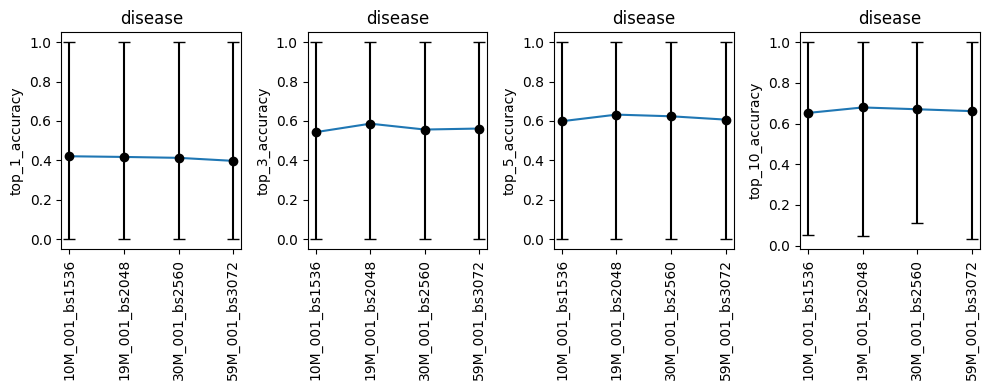

In [12]:
key = 'disease'

metrics = ["top_1_accuracy", "top_3_accuracy", "top_5_accuracy", "top_10_accuracy"]
n_metrics = len(metrics)

fig, axs = plt.subplots(1, n_metrics, figsize=(2.5 * n_metrics, 4))

for i_metric, metric in enumerate(metrics):
    ax = axs[i_metric]

    full_metric = f"{key}_{metric}"
    df_metric = df[[full_metric, "prefix"]].copy()
    df_metric = df_metric.dropna()
    
    stats = df_metric.groupby('prefix').agg(
        median=(full_metric, np.median),
        mean=(full_metric, np.mean),
        q1=(full_metric, lambda x: x.quantile(0.25)),
        q3=(full_metric, lambda x: x.quantile(0.75))
    ).reindex(_PREFIX_LIST)
    y_vals = stats['mean']
    y_err_lower = y_vals - stats['q1']
    y_err_upper = stats['q3'] - y_vals
    y_err = [y_err_lower.values, y_err_upper.values]

    ax.errorbar(
        np.arange(len(_PREFIX_LIST)), y_vals, yerr=y_err,
        fmt='o', color='black', ecolor='black',
        capsize=4, markersize=6, linestyle='None'
    )

    ax.plot(np.arange(len(_PREFIX_LIST)), y_vals)

    # rotate the x-axis labels by 90 degrees
    ax.set_xticks(np.arange(len(_PREFIX_LIST)))
    ax.set_xticklabels(_PREFIX_LIST, rotation=90)
    ax.set_title(key)
    ax.set_ylabel(metric)

fig.tight_layout()

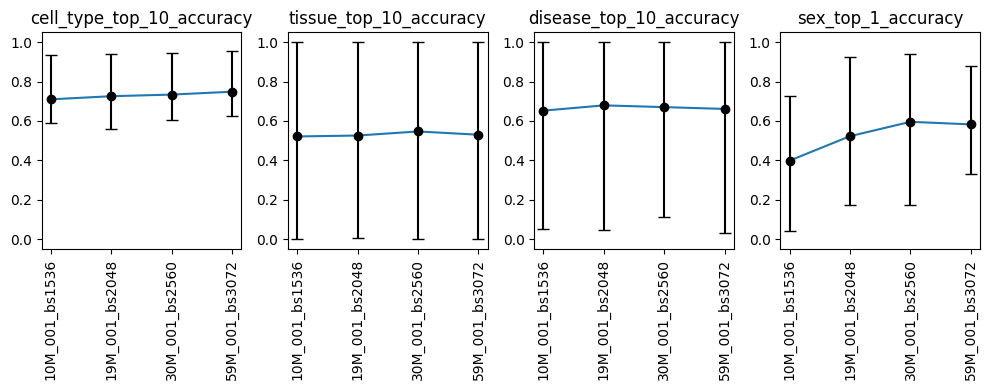

In [13]:
metrics = ["cell_type_top_10_accuracy", "tissue_top_10_accuracy", "disease_top_10_accuracy", "sex_top_1_accuracy"]
n_metrics = len(metrics)

fig, axs = plt.subplots(1, n_metrics, figsize=(2.5 * n_metrics, 4))

for i_metric, metric in enumerate(metrics):
    ax = axs[i_metric]

    df_metric = df[[metric, "prefix"]].copy()
    df_metric = df_metric.dropna()
    
    stats = df_metric.groupby('prefix').agg(
        median=(metric, np.median),
        mean=(metric, np.mean),
        q1=(metric, lambda x: x.quantile(0.25)),
        q3=(metric, lambda x: x.quantile(0.75))
    ).reindex(_PREFIX_LIST)
    y_vals = stats['mean']
    y_err_lower = y_vals - stats['q1']
    y_err_upper = stats['q3'] - y_vals
    y_err = [y_err_lower.values, y_err_upper.values]

    ax.errorbar(
        np.arange(len(_PREFIX_LIST)), y_vals, yerr=y_err,
        fmt='o', color='black', ecolor='black',
        capsize=4, markersize=6, linestyle='None'
    )

    ax.plot(np.arange(len(_PREFIX_LIST)), y_vals)

    # rotate the x-axis labels by 90 degrees
    ax.set_xticks(np.arange(len(_PREFIX_LIST)))
    ax.set_xticklabels(_PREFIX_LIST, rotation=90)
    ax.set_title(metric)
    ax.set_ylim((-0.05, 1.05))
    # ax.set_ylabel()

fig.tight_layout()

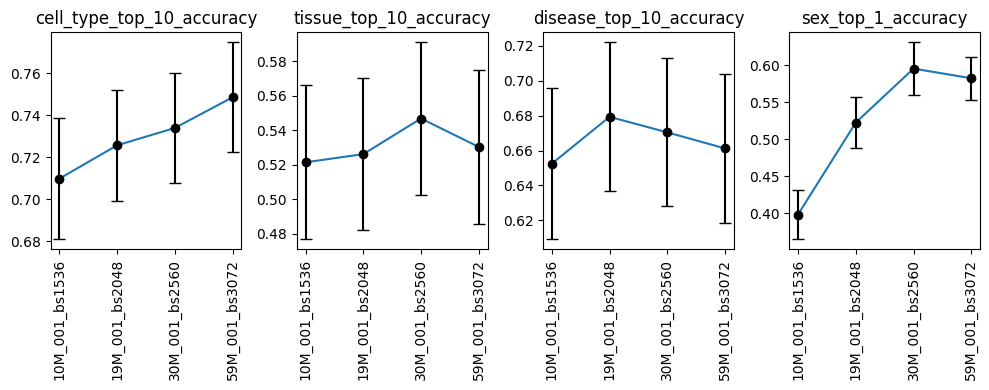

In [14]:
metrics = ["cell_type_top_10_accuracy", "tissue_top_10_accuracy", "disease_top_10_accuracy", "sex_top_1_accuracy"]
n_metrics = len(metrics)

fig, axs = plt.subplots(1, n_metrics, figsize=(2.5 * n_metrics, 4))

for i_metric, metric in enumerate(metrics):
    ax = axs[i_metric]

    df_metric = df[[metric, "prefix"]].copy()
    df_metric = df_metric.dropna()
    
    stats = df_metric.groupby('prefix').agg(
        median=(metric, np.median),
        mean=(metric, np.mean),
        std=(metric, np.std),
        count=(metric, 'count'),
        q1=(metric, lambda x: x.quantile(0.25)),
        q3=(metric, lambda x: x.quantile(0.75))
    ).reindex(_PREFIX_LIST)
    y_vals = stats['mean']
    y_err = stats['std'] / np.sqrt(stats['count'])

    ax.errorbar(
        np.arange(len(_PREFIX_LIST)), y_vals, yerr=y_err,
        fmt='o', color='black', ecolor='black',
        capsize=4, markersize=6, linestyle='None'
    )

    ax.plot(np.arange(len(_PREFIX_LIST)), y_vals)

    # rotate the x-axis labels by 90 degrees
    ax.set_xticks(np.arange(len(_PREFIX_LIST)))
    ax.set_xticklabels(_PREFIX_LIST, rotation=90)
    ax.set_title(metric)
    # ax.set_ylim((-0.05, 1.05))
    # ax.set_ylabel()

fig.tight_layout()

In [ ]:
for metric in metrics:
    fig, ax = plt.subplots(figsize=(6,5))

    # --- Half Violin Plot (the "raincloud" part) ---
    sns.violinplot(
        x="prefix", 
        y=metric, 
        data=df,
        hue=True,
        hue_order=[True, False],
        split=True,
        bw=0.2,
        ax=ax
    )
    ax.legend_ = None
    # Title etc.
    ax.set_title(f"Distribution of {metric} by prefix")
    plt.tight_layout()
    plt.show()


In [ ]:
def _format_axis(ax, category, horizontal=False, keep_variable_axis=True):

    # Remove the axis lines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if horizontal:
        ax.set_ylabel(None)
        lim = ax.get_ylim()
        ax.set_yticks([(lim[0] + lim[1]) / 2])
        ax.set_yticklabels([category])
        if not keep_variable_axis:
            ax.get_xaxis().set_visible(False)
            ax.spines["bottom"].set_visible(False)
    else:
        ax.set_xlabel(None)
        lim = ax.get_xlim()
        ax.set_xticks([(lim[0] + lim[1]) / 2])
        ax.set_xticklabels([category], rotation=90)
        if not keep_variable_axis:
            ax.get_yaxis().set_visible(False)
            ax.spines["left"].set_visible(False)

def categorical_kde_plot(
    df,
    variable,
    category,
    category_order=None,
    horizontal=False,
    rug=True,
    figsize=None,
):
    """Draw a categorical KDE plot

    Parameters
    ----------
    df: pd.DataFrame
        The data to plot
    variable: str
        The column in the `df` to plot (continuous variable)
    category: str
        The column in the `df` to use for grouping (categorical variable)
    horizontal: bool
        If True, draw density plots horizontally. Otherwise, draw them
        vertically.
    rug: bool
        If True, add also a sns.rugplot.
    figsize: tuple or None
        If None, use default figsize of (7, 1*len(categories))
        If tuple, use that figsize. Given to plt.subplots as an argument.
    """
    if category_order is None:
        categories = list(df[category].unique())
    else:
        categories = category_order[:]

    # figsize = (7, 1.0 * len(categories))

    fig, axes = plt.subplots(
        nrows=len(categories) if horizontal else 1,
        ncols=1 if horizontal else len(categories),
        figsize=figsize[::-1] if not horizontal else figsize,
        sharex=horizontal,
        sharey=not horizontal,
    )

    for i, (cat, ax) in enumerate(zip(categories, axes)):
        sns.kdeplot(
            data=df[df[category] == cat],
            x=variable if horizontal else None,
            y=None if horizontal else variable,
            # kde kwargs
            bw_adjust=0.5,
            clip_on=False,
            fill=True,
            alpha=1,
            cut=0,
            linewidth=1.5,
            ax=ax,
            color="lightslategray",
        )

        keep_variable_axis = (i == len(fig.axes) - 1) if horizontal else (i == 0)

        if rug:
            sns.rugplot(
                data=df[df[category] == cat],
                x=variable if horizontal else None,
                y=None if horizontal else variable,
                ax=ax,
                color="black",
                height=0.1,
            )

        _format_axis(
            ax,
            cat,
            horizontal,
            keep_variable_axis=keep_variable_axis,
        )

    fig.tight_layout()

    return fig

In [ ]:
for coarse_tissue in df['coarse_tissue'].unique():
    for metric in metrics:
        fig = categorical_kde_plot(
            df[df['coarse_tissue'] == coarse_tissue],
            metric,
            "prefix",
            horizontal=False,
            figsize=(4, 4),
        )

        fig.gca().set_title(f"{coarse_tissue} - {metric}")